# Gauss-Newton for XRD

In [96]:
from XRDXRFutils import GaussNewton,DataXRD,SpectraXRD,DatabaseXRD,PhaseList

from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca,savefig
from numpy import prod,array,minimum,maximum,log,zeros,trapz,where,amax,max,sqrt,sign
from numpy.linalg import eig,det
from multiprocessing import Pool

### loading data

In [2]:
path = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'


data = DataXRD().load_h5(path + 'data.h5')
data.opt = [-1186.6, 1960.3, 51]

database = DatabaseXRD().read_cifs('/home/zdenek/Projects/XRDXRFutils/Database')

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][0]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]

phases = PhaseList([hydrocerussite,lazurite,cinnabar])

Loading: /home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/data.h5


In [3]:
class PhaseSearch(list):
    """
    Class to perform phase search.
    """
    def __init__(self,phases,spectra):
        super().__init__([GaussNewton(phase,spectra) for phase in phases])
        
        self.spectra = spectra
        self.intensity = spectra.intensity
        
        self.opt = self[0].opt
        for g in self:
            g.opt = self.opt
        
    def minimize_gamma(self,n=4):
        for g in self:
            for i in range(n):
                g.minimize_gamma()
                
    def overlap_area(self):
        return array([g.overlap_area() for g in self])
    
    def loss(self):
        return array([g.loss() for g in self])
    
    def select(self):
        idx = self.overlap_area().argmax()
        selected = self[idx]
        
        self.idx = idx
        self.selected = selected
        
        return selected
    
    def theta_correction(self,n=4):
        for i in range(n):
            self.select().calibration()
            
    def search(self):
        
        self.minimize_gamma()
        
        self.select()
        self.theta_correction()
        self.minimize_gamma()
        
        self.select()
        self.theta_correction()
        self.minimize_gamma()
        
        return self
    
class PhaseMap(list):
    """
    Class to process images
    """      
    def from_data(self,data,phases):
    
        phases.get_theta(max_theta=53,min_intensity=0.05)
        arr = data.data.reshape(-1,1280)

        spectras = self.gen_spectras(arr)        
        for spectra in spectras:
            spectra.opt = [-1186.6, 1960.3, 51]
        
        self += [PhaseSearch(phases,spectra) for spectra in spectras]
        
        return self
    
    @staticmethod
    def f_spectra(x):
        return SpectraXRD().from_array(x)

    def gen_spectras(self,a):
        with Pool() as p:
            spectras = p.map(self.f_spectra,a)
        return spectras
    
    @staticmethod
    def f_search(x):
        return x.search()
    
    def search(self):
        with Pool() as p:
            result = p.map(self.f_search,self)
        return PhaseMap(result)

In [4]:
%%time
pm = PhaseMap().from_data(data,phases)

CPU times: user 2.32 s, sys: 876 ms, total: 3.2 s
Wall time: 2.79 s


In [5]:
%%time
result = pm.search()

CPU times: user 8.54 s, sys: 2.39 s, total: 10.9 s
Wall time: 1min 28s


[-1190.694902322507, 1966.6569173733935, 51]


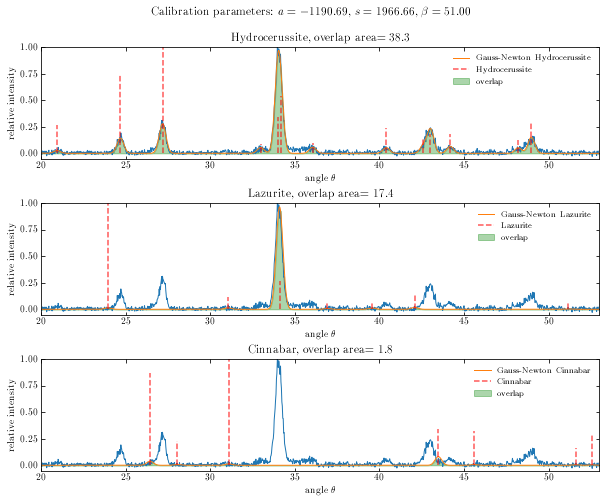

In [6]:
%matplotlib inline
r = result[1600]
r = result[160]

fig,ax = subplots(len(r),1,figsize=(10,7))
fig.subplots_adjust(hspace=0.4,bottom=0.06,top=0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0],r.opt[1],r.opt[2]))
                  
for i,g in enumerate(r):
    
    sca(ax[i])
    
    ax[i].set_title('%s, overlap area= %.1f'%(g.label,g.overlap_area()))
    g.plot_spectra(lw=1)
    g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
    g.phase.plot('r',alpha=0.66)

    fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

    legend(frameon=False)
    ylim(-0.05,1)
    xlim(20,53)
    xlabel(r'angle $\theta$')
    ylabel(r'relative intensity')
    
#savefig('doc/calibrated_phases.png')

## Calibration

per pixel calibration dependence

a,b: [-3.80357307e-01 -4.40777843e+02] [ -0.83250184 445.3777511 ]
-1186.7678305025347 1961.2873861160376


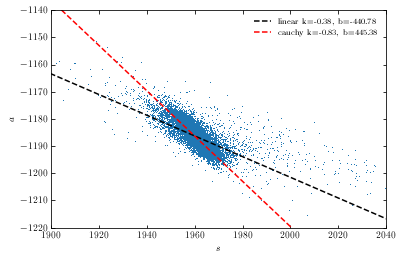

In [7]:
%matplotlib inline
from numpy import linspace
from scipy.optimize import curve_fit,least_squares

def f(x,a,b):
    return a*x + b
def loss(x,t,y):
    return (x[0]*t + x[1]) - y

a = array([r.selected.opt[0] for r in result])
s = array([r.selected.opt[1] for r in result])
x = linspace(s.min(),s.max())

opt,var = curve_fit(f,s,a)

res = least_squares(loss,x0=opt,args=(s,a),loss='cauchy')
print('a,b:',opt,res['x'])

linear_y = f(x,*opt)
cauchy_y = f(x,*res['x'])

plot(s,a,',')
plot(x,linear_y,'k--',label='linear k=%.2f, b=%.2f'%(opt[0],opt[1]))
plot(x,cauchy_y,'r--',label='cauchy k=%.2f, b=%.2f'%(res['x'][0],res['x'][1]))

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

print(a.mean(),s.mean())
#savefig('doc/fit_as.png')

## Pair compositions

In [82]:
n = len(r)
A = zeros((n,n))
C = zeros((n,n))

norm = trapz(where(r.intensity>0,r.intensity,0))
for i,ra in enumerate(r):
    
    A[i,i] = ra.overlap_area()
    
    for j,rb in enumerate(r[i+1:]):

        m = maximum(ra.z(),rb.z())
        m = minimum(m,r.intensity)
        t = trapz(where(m>0,m,0))
        
        A[i,i + j + 1] = t
        A[i + j + 1,i] = t
        
        m = minimum(ra.z(),rb.z())
        m = minimum(m,r.intensity)
        t = trapz(where(m>0,m,0))
        
        C[i,i + j + 1] = t
        C[i + j + 1,i] = t

(array([[38.26104516, 39.19552597, 39.30432114],
        [39.19552597, 17.41844091, 19.06306213],
        [39.30432114, 19.06306213,  1.79991147]]),
 array([[1.        , 0.4443987 , 0.04579424],
        [0.97615848, 1.        , 0.0944188 ],
        [0.97345646, 0.91372733, 1.        ]]),
 array([[ 0.        , 16.48396011,  0.75663549],
        [16.48396011,  0.        ,  0.15529025],
        [ 0.75663549,  0.15529025,  0.        ]]))

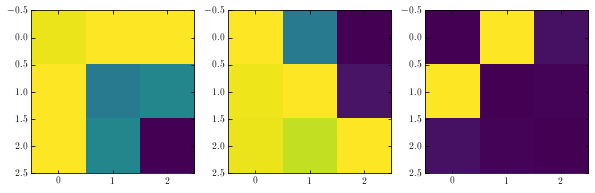

In [83]:
%matplotlib inline

B = A.diagonal()/A

fig,ax = subplots(1,3,figsize=(10,3))
ax[0].imshow(A)
ax[1].imshow(B)
ax[2].imshow(C)

A,B,C

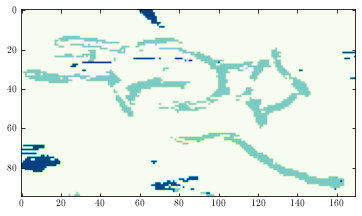

In [49]:
%matplotlib inline
idx = array([r.idx for r in result]).reshape(95,170)
imshow(idx,cmap='GnBu')

In [164]:
%%time
area = array([r.overlap_area() for r in result])
loss = array([r.loss() for r in result])
ss = array([trapz(r.spectra.intensity) for r in result])

CPU times: user 20.9 s, sys: 21.2 ms, total: 20.9 s
Wall time: 20.9 s


In [165]:
area = area.reshape(95,170,-1)
loss = loss.reshape(95,170,-1)
ss = ss.reshape(95,170)

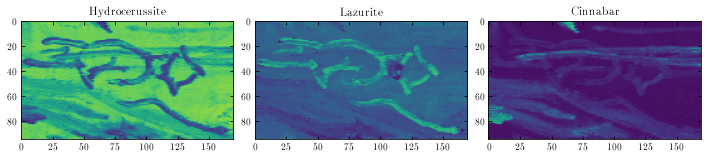

In [174]:
%matplotlib inline

fig,ax = subplots(1,3,figsize=(10,3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area[:,:,i]/ss,vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)
    
#savefig('doc/maps.png')

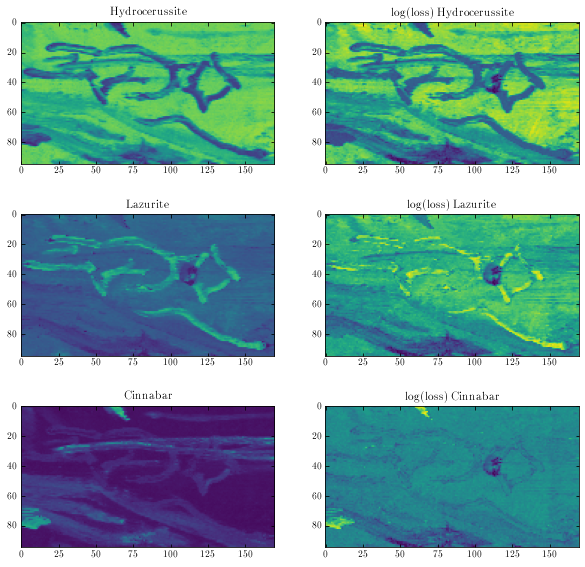

In [176]:
%matplotlib inline
fig,ax = subplots(3,2,figsize=(10,10))

for i,g in enumerate(g_list):

    ax[i,0].imshow(area[:,:,i]/ss,vmin=0,vmax=1)    
    ax[i,1].imshow(-log(loss[:,:,i]))
    
    ax[i,0].set_title(r'%s'%g.label)
    ax[i,1].set_title(r'log(loss) %s'%g.label)

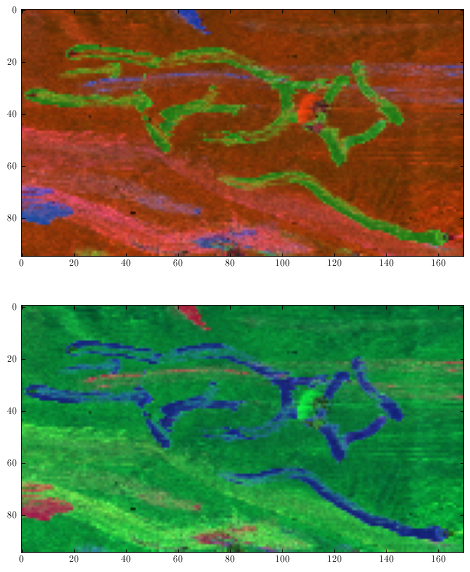

In [178]:
fig,ax = subplots(2,1,figsize=(10,10))

zarea = area / max(area)

sarea = zarea.copy()
sarea[:,:,0] = zarea[:,:,2]
sarea[:,:,1] = zarea[:,:,0]
sarea[:,:,2] = zarea[:,:,1]

ax[0].imshow((zarea*255).astype(int))
ax[1].imshow((sarea*255).astype(int))

### Modified Pseudo-Huber loss

To mitigate the negative $\gamma$ instability 

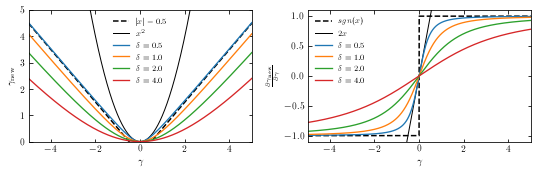

In [149]:
%matplotlib inline

def huber(x,delta):
    return delta * (sqrt(1 + (x/delta)**2) - 1)

def dhuber(x,delta):
    return x/(delta*sqrt(x**2/delta**2 + 1))

x = linspace(-30,30,10000)

#plot(x,abs(x),'k-')

fig,ax = subplots(1,2,figsize=(9,2.5))
fig.subplots_adjust(wspace=0.25,bottom=0.15)

ax[0].plot(x,abs(x)-0.5,'k--',label=r'$|x|-0.5$')
ax[0].plot(x,x**2,'k-',lw=1,label=r'$x^2$')

ax[0].set_xlim(-5,5)
ax[0].set_ylim(-0,5)

for delta in [0.5,1,2,4]:
    ax[0].plot(x,huber(x,delta) ,'-',lw=1.33,label=r'$\delta=%.1f$'%delta)
ax[0].legend(frameon=False)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$\gamma_\mathrm{new}$')

ax[1].plot(x,sign(x),'k--',label=r'$sgn(x)$')
ax[1].plot(x,2*x,'k-',lw=1,label=r'$2x$')

ax[1].set_xlim(-5,5)
ax[1].set_ylim(-1.1,1.1)

for delta in [0.5,1,2,4]:
    ax[1].plot(x,dhuber(x,delta) ,'-',lw=1.33,label=r'$\delta=%.1f$'%delta)
ax[1].legend(frameon=False)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$\frac{\partial\gamma_\mathrm{new}}{\partial\gamma}$')

savefig('doc/gamma_new.png')